# Design of comparative analysis

In this notebook we benchmark the ability to recover query-specific cell phenotypes using 3 alternative designs for comparative analysis

- Atlas reference (AR design): mapping perturbed cells to an all-encompassing atlas dataset
- Control reference (CR design): mapping perturbed cells to a matched control dataset
- Atlas and Control reference (ACR design): mapping perturbed and control cells to an all-encompassing atlas dataset

We use 4 different metrics to assess the accuracy of query-specific cell detection:
- Differential abundance analysis with milo
- Uncertainty over labels, using KNN classifier as implemented in scArches
- Uncertainty over reconstructed gene expression profiles: ~ reconstruction error per cell after scArches
- Uncertainty over latent space: average distance of posterior samples to inferred position in scVI bottleneck layer


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [14]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

### Experiment set-up

```
python run_design_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${p} --outpath ${outdir}
python run_design_merge.py ${outdir}${d}/
python run_milo.py ${outdir}${d}/
```


### Parse results 

In [15]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [9]:

def _gauss_kernel(dist_nns):
    # compute standard deviation
    std_d = np.sqrt(sum(np.sqrt(dist_nns))/dist_nns.shape[0])
    # apply gaussian kernel
    adj_dist_nns = np.exp(-dist_nns/np.square(2/std_d))
    return(adj_dist_nns)

def _add_perturb_pop_info(pac_design_adata, min_perturb_cells = 10):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def get_mean_confidence_x_nhood(adata, obs_names, confidence_col = 'conf_gex'):
    '''
    Compute average confidence per neighbourhood using a subset of cells
    '''
    nhood_mat = adata[obs_names].obsm['nhoods']
    mean_conf_nhoods = nhood_mat.T.dot(
            scipy.sparse.csr_matrix(adata.obs.loc[obs_names, confidence_col]).T)
    mean_conf_nhoods = mean_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
    mean_conf_nhoods = np.nan_to_num(mean_conf_nhoods, 0) ## zero confidence where we have no cells
    return(mean_conf_nhoods)

def add_nhood_uncertainties(pac_design_adata, ref_group):
    pac_design_adata.obs['uncertainty_z'] = 1 - _gauss_kernel(pac_design_adata.obs['uncertainty_z'])
    pac_design_adata.obs['conf_labels'] = 1 - pac_design_adata.obs['uncertainty_labels']
    pac_design_adata.obs['conf_gex'] = 1 - pac_design_adata.obs['uncertainty_gex']
    pac_design_adata.obs['conf_z'] = 1 - pac_design_adata.obs['uncertainty_z']

    for c in ['conf_gex', 'conf_labels', 'conf_z']:
        get_nhood_adata(pac_design_adata).obs[c] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] != ref_group], confidence_col=c)


In [15]:

nhood_obs_all = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if not x.endswith('.h5ad') and x.startswith('qPBMC')][1:]:
    perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad', backed=True)
    pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad', backed=True)
    pc_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pc_design.h5ad', backed=True)

    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata)
    _add_perturb_pop_info(pa_design_adata)
    _add_perturb_pop_info(pc_design_adata)

    # ## Calculate avg confidence per nhood
    print(f'Calculating avg confidence')
    add_nhood_uncertainties(pac_design_adata, ref_group='atlas')
    add_nhood_uncertainties(pa_design_adata, ref_group='atlas')
    add_nhood_uncertainties(pc_design_adata, ref_group='ctrl')

    ## Store nhood info
    des_dict = {'PAC':pac_design_adata, "PA": pa_design_adata, "PC": pc_design_adata}
    for design, adata in des_dict.items():
        nhood_obs = get_nhood_adata(adata).obs.copy()
        nhood_obs['design'] = design
        nhood_obs['perturb_pop'] = perturb_pop
        nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

Reading conventional_dendritic_cell

Calculating avg confidence


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Reading naive_B_cell

Calculating avg confidence
Reading central_memory_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading plasmablast

Calculating avg confidence
Reading platelet

Calculating avg confidence
Reading plasmacytoid_dendritic_cell

Calculating avg confidence
Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading classical_monocyte

Calculating avg confidence
Reading erythrocyte

Calculating avg confidence
Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading natural_killer_cell

Calculating avg confidence
Reading effector_memory_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading mucosal_invariant_T_cell

Calculating avg confidence
Reading CD14_low_CD16_positive_monocyte

Calculating avg confidence


In [13]:
# nhood_obs_all.to_csv(outdir + 'design_comparison.nhood_obs_all.csv')

In [16]:
nhood_obs_all.to_csv(outdir + 'design_comparison.nhood_obs_all.target_n_nhood.csv')

In [16]:
nhood_obs_all = pd.read_csv(outdir + 'design_comparison.nhood_obs_all.target_n_nhood.csv', index_col=0)

In [25]:

rename_design = {'PAC':'ACR', 'PC':"CR", "PA":"AR"}
if any(nhood_obs_all['design'] == 'PAC'):
    nhood_obs_all['design'] = [rename_design[x] for x in nhood_obs_all['design']]


In [28]:

short_pop_names = {"DC":'conventional_dendritic_cell', 
 "naive B":'naive_B_cell',
 "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell',
 'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

nhood_obs_all['perturb_pop_pl'] = [short_pop_names[x] for x in nhood_obs_all['perturb_pop']]

In [29]:
## Define perturbed neighbourhoods by maximum fraction of cells from the query-specific cluster
# (use as threshold 20% of max fraction)
for d in ['ACR', "AR", "CR"]:
    for p in nhood_obs_all.perturb_pop.unique():
        frac_group = nhood_obs_all[(nhood_obs_all.design == d) & (nhood_obs_all.perturb_pop == p)]['frac_perturb_cells']
        max_frac = frac_group.max()
        thresh = 20*(max_frac/100)
        nhood_obs_all.loc[(nhood_obs_all.design == d) & (nhood_obs_all.perturb_pop == p), 'is_perturb_nhood'] = frac_group > thresh

In [167]:
# ## Exclude populations with too few cells
# nhood_obs_all = nhood_obs_all[~nhood_obs_all.perturb_pop.isin(['plasmablast', 'plasmacytoid_dendritic_cell', 'erythrocyte'])].copy()

In [30]:
# cts = nhood_obs_all.perturb_pop_pl.unique()
# # cts = ['classical_monocyte', 'natural_killer_cell', 'naive_B_cell']
# with rc_context({'figure.figsize':[10,35]}):
#     fig,axs = plt.subplots(len(cts), 1)
#     for i, ct in enumerate(cts):
#         axs[i].axhline(y=0, color='r', linewidth=1, linestyle='--');
#         sns.boxplot(
#             data=nhood_obs_all[nhood_obs_all['perturb_pop_pl'] == ct], 
#             hue='is_perturb_nhood', y='logFC', x='design', ax=axs[i]
#         );
#         if i == 0:
#             axs[i].legend(
#                 bbox_to_anchor=(1.05, 1), 
#                 loc='upper left', 
#                 borderaxespad=0,
#                 frameon=False,
#                 title='Query-specific pop');
#         else:
#             axs[i].legend([],[], frameon=False)
#         if i < (len(axs)-1):
#             remove_x_axis(axs[i])
#         axs[i].set_title(make_ct_label(ct))
#     fig.tight_layout()
#     fig.savefig(figdir + 'DAlogFC_boxplot.png');
    

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


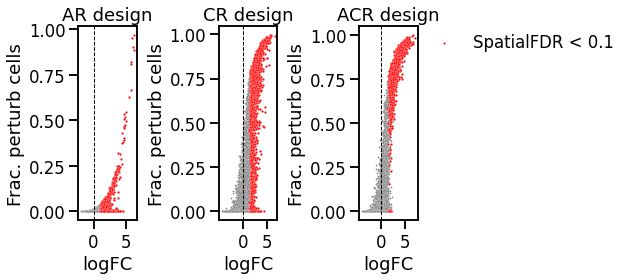

In [31]:
nhood_obs_all['signif_DA'] = (nhood_obs_all.SpatialFDR <= 0.1) & (nhood_obs_all.logFC > 0)
with rc_context({'figure.figsize':[15,5]}):
    for i,d in enumerate(["AR", "CR", 'ACR']):
        plt.subplot(1,3,i+1)
        sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design==d], x='logFC',  y='frac_perturb_cells',  s=3, color='grey');
        sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.design==d) & (nhood_obs_all.signif_DA)], x='logFC',  y='frac_perturb_cells',  s=5, color='red', label='SpatialFDR < 0.1');
        if i==2:
            plt.legend(bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    borderaxespad=0,
                    frameon=False)
        else:
            plt.legend([],[], frameon=False)
        plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
        plt.title(f'{d} design');
        plt.ylabel("Frac. perturb cells");
        plt.tight_layout();
    plt.savefig(figdir + 'fracVSlogFC_all.pdf')

In [107]:
# with rc_context({'figure.figsize':[15,5]}):
#     for i,d in enumerate(['PAC', "PA", "PC"]):
#         plt.subplot(1,3,i+1)
#         sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design==d], x='unc_gex',  y='frac_perturb_cells',  s=3, color='grey');
#         sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.design==d) & (nhood_obs_all.is_perturb_nhood)], x='unc_gex',  y='n_perturb_cells',  s=5, color='red', label='TP');
#         plt.title(f'{d} design');
#         plt.ylabel("Frac. perturb cells");
#         plt.tight_layout()

# with rc_context({'figure.figsize':[15,5]}):
#     for i,d in enumerate(['PAC', "PA", "PC"]):
#         plt.subplot(1,3,i+1)
#         sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design==d], x='unc_labels',  y='frac_perturb_cells',  s=3, color='grey');
#         sns.scatterplot(data=nhood_obs_all[(nhood_obs_all.design==d) & (nhood_obs_all.is_perturb_nhood)], x='unc_labels',  y='n_perturb_cells',  s=5, color='red', label='TP');
#         plt.title(f'{d} design');
#         plt.ylabel("Frac. perturb cells");
#         plt.tight_layout()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


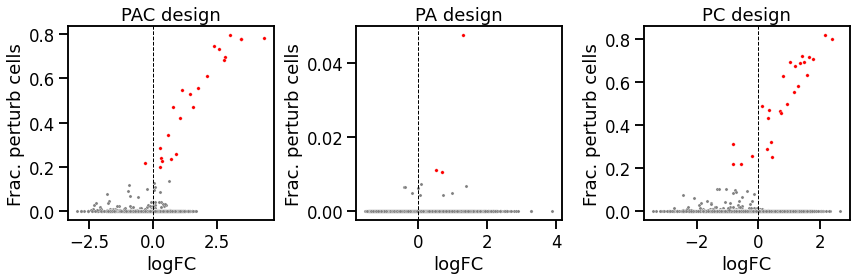

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


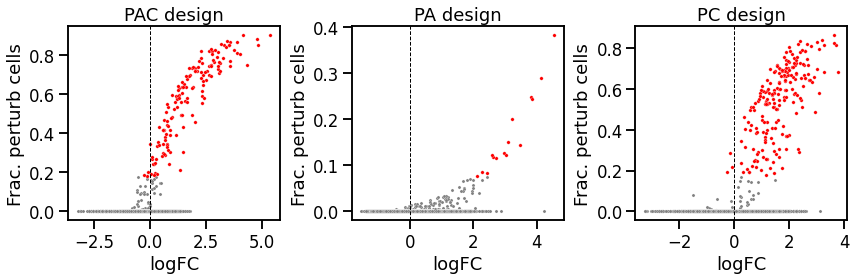

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


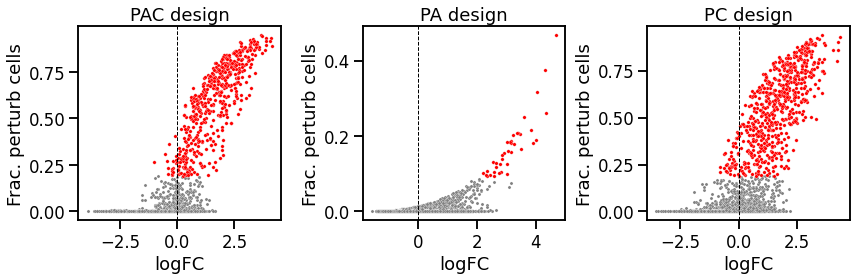

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


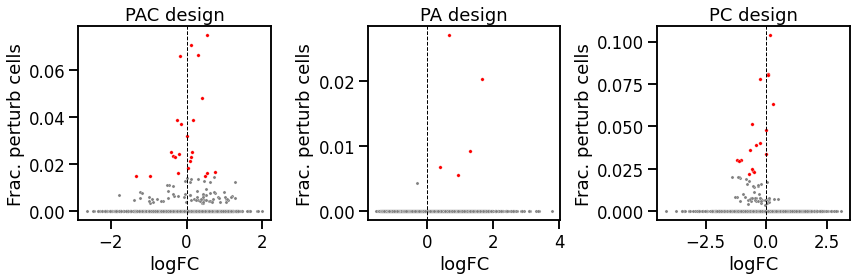

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


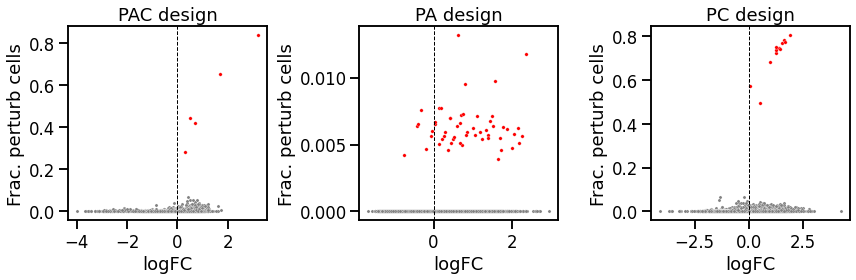

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


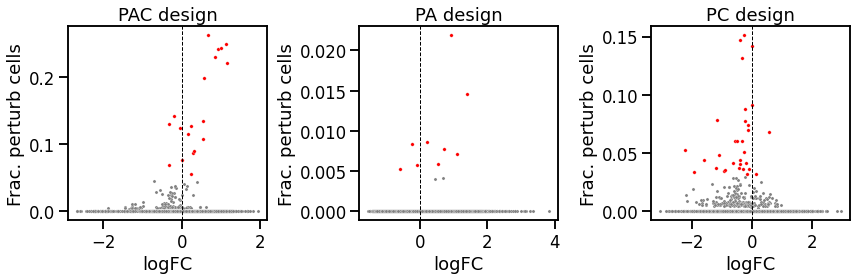

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


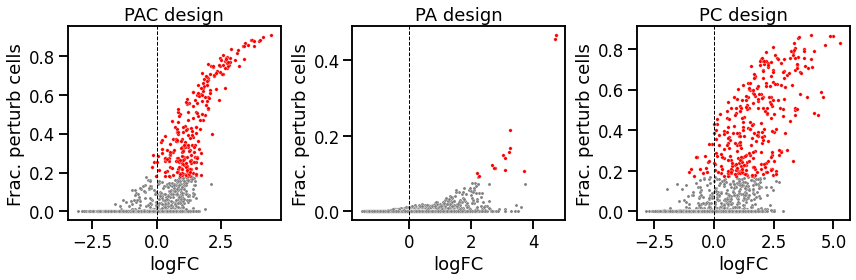

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


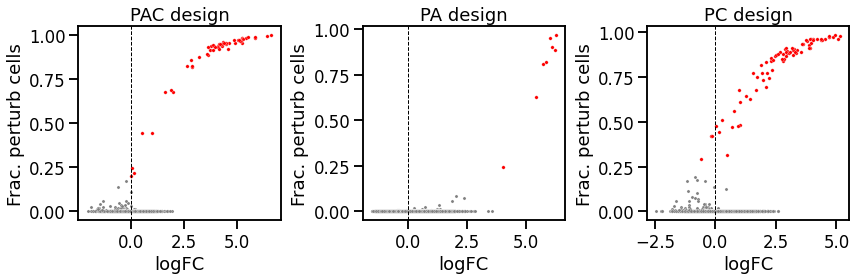

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


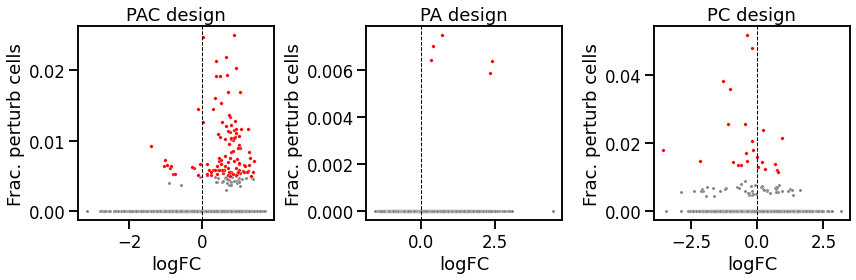

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


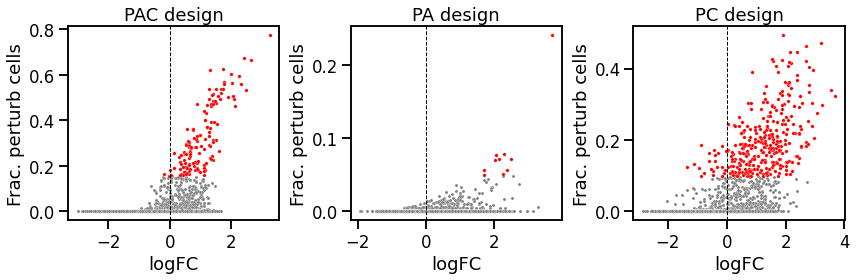

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


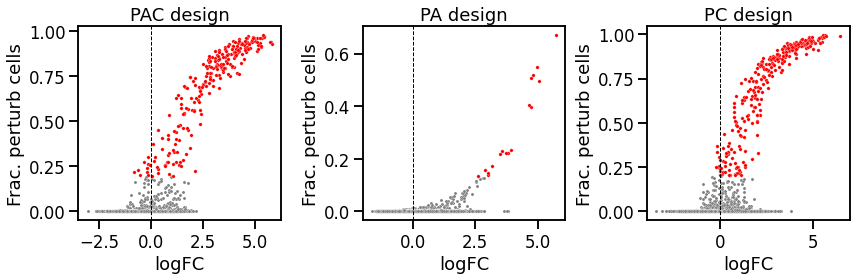

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


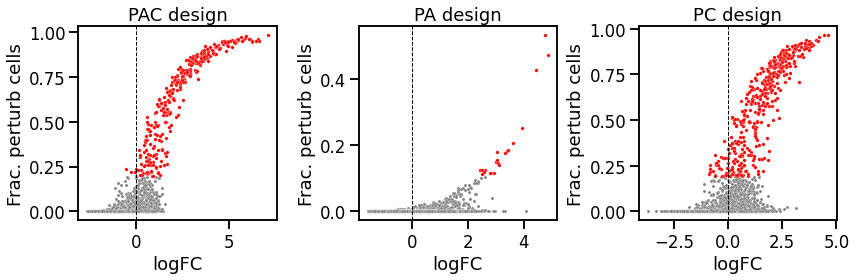

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


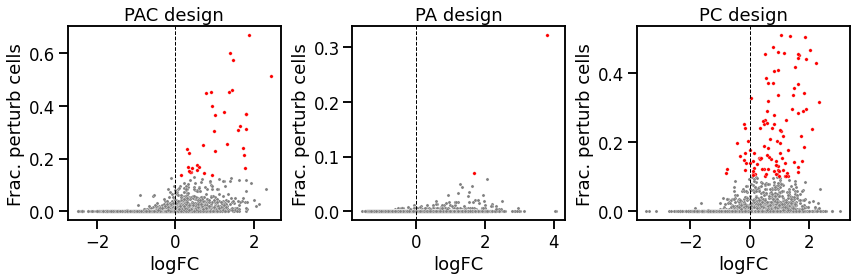

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


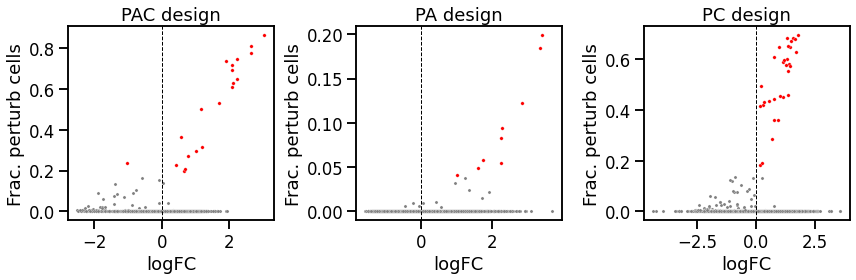

In [31]:
cts = nhood_obs_all.perturb_pop.unique()
for ct in cts:
    nhood_obs = nhood_obs_all[nhood_obs_all.perturb_pop == ct]
    nhood_obs['signif_DA'] = (nhood_obs.SpatialFDR <= 0.1) & (nhood_obs.logFC > 0)
    with rc_context({'figure.figsize':[12,4]}):
        for i,d in enumerate(['PAC', "PA", "PC"]):
            plt.subplot(1,3,i+1)
            sns.scatterplot(data=nhood_obs[nhood_obs.design==d], x='logFC',  y='frac_perturb_cells',  s=10, color='grey');
            sns.scatterplot(data=nhood_obs[(nhood_obs.design==d) & (nhood_obs.is_perturb_nhood)], x='logFC',  y='frac_perturb_cells',  s=12, color='red');
            plt.axvline(x=0, color='black', linewidth=1, linestyle='--'); 
            plt.title(f'{d} design');
            plt.ylabel("Frac. perturb cells");
            plt.tight_layout();
    plt.savefig(figdir + f'N_cells_logFC_{ct}.png');
    plt.show()

In [32]:
%%R -i nhood_obs_all
head(nhood_obs_all)

                                            index_cell kth_distance
1 10_1038_s41591_021_01329_2-BGCV01_CACTCCAGTCCGTCAG-1     1.842600
2 10_1038_s41591_021_01329_2-BGCV01_CCCAATCGTTCGTGAT-1     1.082477
3 10_1038_s41591_021_01329_2-BGCV01_GTCATTTTCGCTGATA-1     1.157062
4 10_1038_s41591_021_01329_2-BGCV01_CTGCCTAAGTAGATGT-1     1.357066
5 10_1038_s41591_021_01329_2-BGCV01_GTAGTCAAGCTGCAAG-1     1.062361
6 10_1038_s41591_021_01329_2-BGCV01_GACGGCTCAAAGGTGC-1     1.049740
     nhood_annotation nhood_annotation_frac      logFC   logCPM           F
1            platelet             0.4367816 -1.0208991 9.036446 1.645807482
2 natural_killer_cell             1.0000000 -0.1466724 9.269045 0.054672784
3 natural_killer_cell             1.0000000  0.8122574 9.342563 1.879559451
4 natural_killer_cell             0.9894737 -0.6271307 9.088889 1.133160279
5 natural_killer_cell             1.0000000  0.1863789 9.529636 0.092124168
6        naive_B_cell             0.8588235 -0.0534535 9.205450 0.00

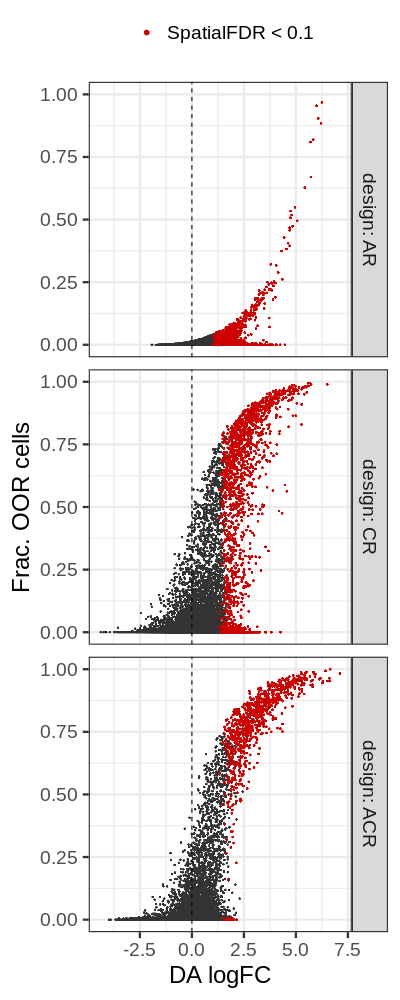

In [44]:
%%R -h 1000 -w 400 -i figdir
library(ggrastr)

nhood_obs_all %>%
mutate(design=factor(design, levels=c('AR', 'CR','ACR'))) %>%
ggplot(aes(logFC, frac_perturb_cells)) +
    rasterise(geom_point(size=0.3, color='grey20'), dpi=300) +
    rasterise(geom_point(data=. %>% filter(signif_DA), aes(color='SpatialFDR < 0.1'),
               size=0.4), dpi=300) +
    facet_grid(design~., labeller='label_both') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
    geom_vline(xintercept=0, linetype=2) +
    xlab('DA logFC') + ylab('Frac. OOR cells') +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'fracVSlogFC_all_ggplot.png'), width=6, height=12) +
    ggsave(paste0(figdir, 'fracVSlogFC_all_ggplot.pdf'), width=6, height=12)

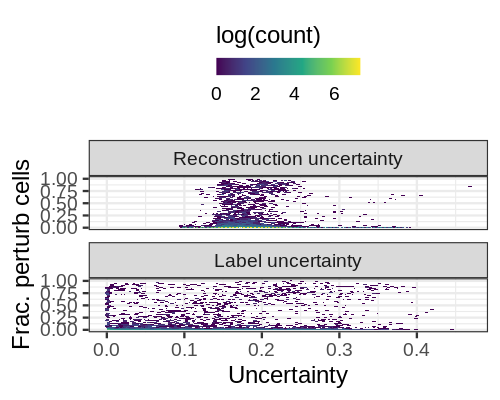

In [329]:
%%R -w 500 -h 400
metric_labels <- c(
  unc_gex = "Reconstruction uncertainty",
  unc_labels = "Label uncertainty"
)

nhood_obs_all %>%
    mutate(design=factor(design, levels=c('PAC', 'PA', "PC"))) %>%
    filter(design == 'PAC') %>%
    mutate(unc_gex = 1 - conf_gex, unc_labels = 1 - conf_labels) %>%
    select(unc_gex, unc_labels, design, frac_perturb_cells) %>%
    pivot_longer(cols=c(unc_gex, unc_labels), names_to='metric') %>%
#     head()
    ggplot(aes(value, frac_perturb_cells)) +
        stat_binhex(aes(fill=log(..count..)), bins=100) +
        facet_wrap(metric~., labeller=labeller(metric = metric_labels), ncol=1) +
        guides(fill=guide_colourbar(barwidth=10, ticks=FALSE, title.position='top')) +
        scale_fill_viridis_c() +
        theme_bw(base_size=24) +
        ylab('Frac. perturb cells') + xlab('Uncertainty') +
        theme(legend.position='top') +
        ggsave(paste0(figdir, 'fracVSunc_all_ggplot.png'), width=6, height=14) +
        ggsave(paste0(figdir, 'fracVSunc_all_ggplot.pdf'), width=6, height=14)

# # p2 <- nhood_obs_all %>%
# #     mutate(design=factor(design, levels=c('PAC', 'PA', "PC"))) %>%
# #     filter(design == 'PAC') %>%
# #     ggplot(aes(1 - conf_labels, frac_perturb_cells)) +
# #         stat_binhex(aes(fill=log(..count..)), bins=100) +
# #         facet_wrap(design~., labeller='label_both') +
# #         guides(fill=guide_colourbar(barwidth=10, ticks=FALSE, title.position='top')) +
# #         scale_fill_viridis_c() +
# #         theme_bw(base_size=24) +
# #         ylab('Frac. perturb cells') + xlab('Label uncertainty') +
# #         theme(legend.position='top') 

# (p1 / p2) + plot_layout(guides='collect')

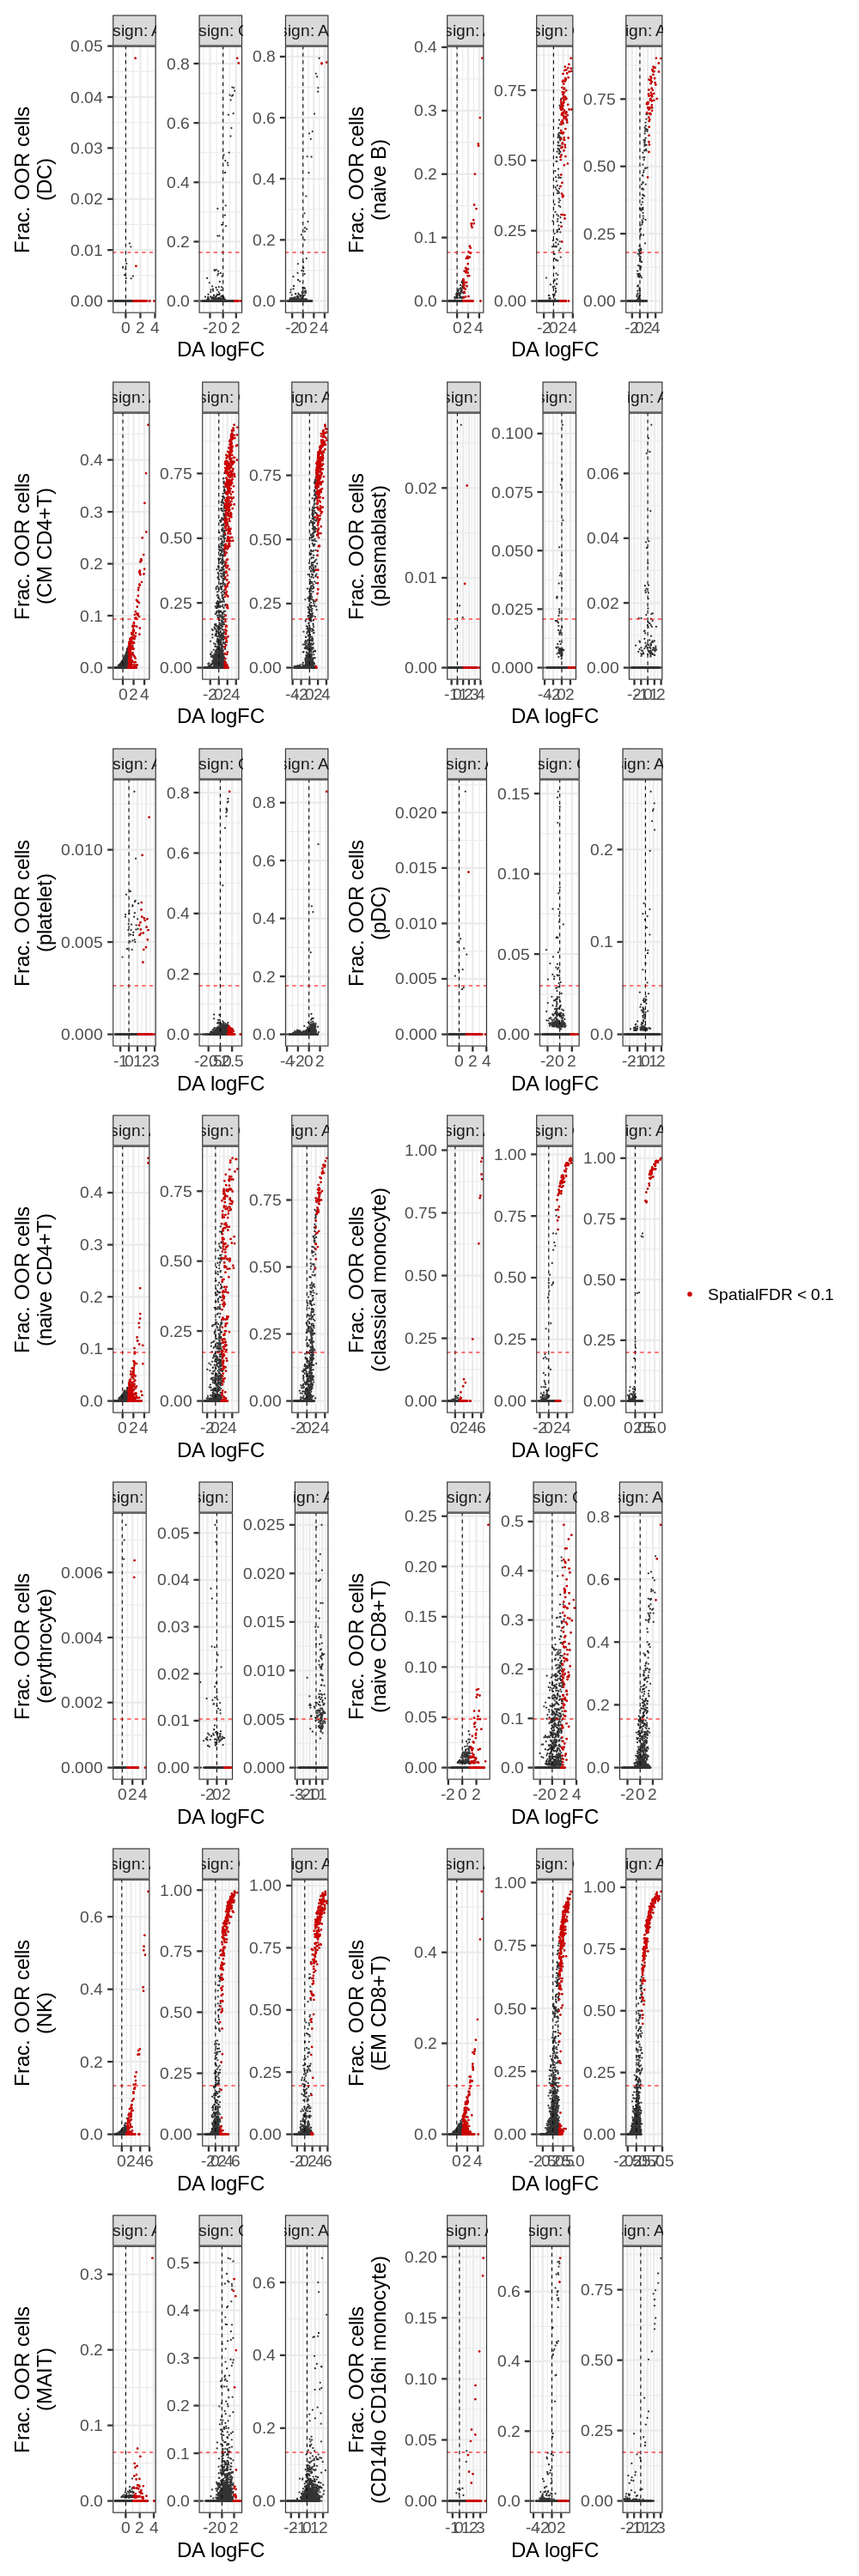

In [45]:
%%R -w 1000 -h 3000
pl_ls <- lapply(unique(nhood_obs_all$perturb_pop_pl), function(p){
    nhood_obs_all %>%
    mutate(design=factor(design, levels=c("AR", 'CR', "ACR"))) %>%
    group_by(perturb_pop_pl, design) %>%
    mutate(frac_thresh= max(frac_perturb_cells/100)*20) %>%
    ungroup() %>%
    filter(perturb_pop_pl %in% c(p)) %>%
    ggplot(aes(logFC, frac_perturb_cells)) +
        geom_point(size=0.4, color='grey20') +
        geom_point(data=. %>% filter(signif_DA), aes(color='SpatialFDR < 0.1'), size=0.6) +
        facet_wrap(design~., labeller=label_both, scales='free') +
        guides(color=guide_legend(title='', override.aes = list(size=2))) +
        theme_bw(base_size=24) +
        scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
        geom_vline(xintercept=0, linetype=2) +
        geom_hline(aes(yintercept=frac_thresh), linetype=2, color='red') +
        xlab('DA logFC') + ylab(glue::glue('Frac. OOR cells\n({p})')) +
#         ggtitle(glue::glue('Perturb-specific population: {p}')) +
        theme(legend.position='top') 
    })

(wrap_plots(pl_ls, ncol=2, guides='collect') & {theme(legend.position='right') }) +
    ggsave(paste0(figdir, 'fracVSlogFC_cts_ggplot.png'), width=24, height=32) +
    ggsave(paste0(figdir, 'fracVSlogFC_cts_ggplot.pdf'), width=24, height=32)


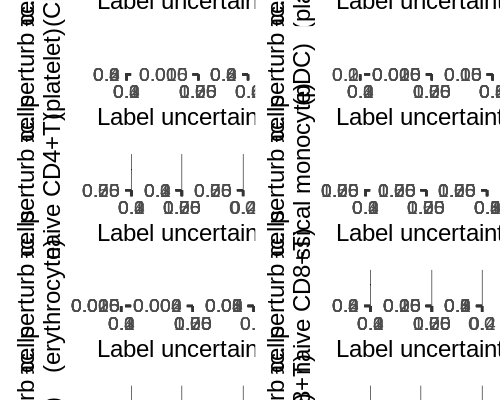

In [336]:
%%R -w 500 -h 400
pl_ls <- lapply(unique(nhood_obs_all$perturb_pop_pl), function(p){
    nhood_obs_all %>%
    mutate(design=factor(design, levels=c('PAC', 'PA', "PC"))) %>%
    group_by(perturb_pop_pl, design) %>%
    mutate(frac_thresh= max(frac_perturb_cells/100)*20) %>%
    ungroup() %>%
    filter(perturb_pop_pl %in% c(p)) %>%
    mutate(unc_gex = 1 - conf_gex, unc_labels = 1 - conf_labels) %>%
#     select(unc_gex, unc_labels, design, frac_perturb_cells, perturb_pop_pl, design, frac_thresh) %>%
#     pivot_longer(cols=c(unc_gex, unc_labels), names_to='metric') %>%
    ggplot(aes(unc_gex, frac_perturb_cells)) +
    stat_binhex(aes(fill=log(..count..)), bins=50) +
    facet_wrap(design~., scales='free',
               labeller=label_both) +
#         facet_wrap(design~., labeller=label_both, scales='free') +
    scale_fill_viridis_c() +    
    guides(fill='none') +
        theme_bw(base_size=24) +
        geom_vline(xintercept=0, linetype=2) +
        geom_hline(aes(yintercept=frac_thresh), linetype=2, color='red') +
        xlab('Reconstruction uncertainty') + ylab(glue::glue('Frac. perturb cells\n({p})')) +
#         ggtitle(glue::glue('Perturb-specific population: {p}')) +
        theme(legend.position='top') 
    })

(wrap_plots(pl_ls, ncol=2, guides='collect') & {theme(legend.position='right') }) +
    ggsave(paste0(figdir, 'fracVSunc_gex_cts_ggplot.png'), width=24, height=32) +
    ggsave(paste0(figdir, 'fracVSunc_gex_cts_ggplot.pdf'), width=24, height=32)
    
pl_ls <- lapply(unique(nhood_obs_all$perturb_pop_pl), function(p){
    nhood_obs_all %>%
    mutate(design=factor(design, levels=c('PAC', 'PA', "PC"))) %>%
    group_by(perturb_pop_pl, design) %>%
    mutate(frac_thresh= max(frac_perturb_cells/100)*20) %>%
    ungroup() %>%
    filter(perturb_pop_pl %in% c(p)) %>%
    mutate(unc_gex = 1 - conf_gex, unc_labels = 1 - conf_labels) %>%
    ggplot(aes(unc_labels, frac_perturb_cells)) +
    stat_binhex(aes(fill=log(..count..)), bins=50) +
    facet_wrap(design~., scales='free',
               labeller=label_both) +
    scale_fill_viridis_c() +    
    guides(fill='none') +
        theme_bw(base_size=24) +
        geom_vline(xintercept=0, linetype=2) +
        geom_hline(aes(yintercept=frac_thresh), linetype=2, color='red') +
        xlab('Label uncertainty') + ylab(glue::glue('Frac. perturb cells\n({p})')) +
#         ggtitle(glue::glue('Perturb-specific population: {p}')) +
        theme(legend.position='top') 
    })

(wrap_plots(pl_ls, ncol=2, guides='collect') & {theme(legend.position='right') }) +
    ggsave(paste0(figdir, 'fracVSunc_labels_cts_ggplot.png'), width=24, height=32) +
    ggsave(paste0(figdir, 'fracVSunc_labels_cts_ggplot.pdf'), width=24, height=32)



### Precision-Recall

In [50]:
from sklearn.metrics import roc_curve,auc
def _compute_metric_AUPRC(out_df_full, metric):
    from sklearn.metrics import roc_curve,auc, precision_recall_curve
    AUPRC_df_all = pd.DataFrame()
    for i,c in enumerate(out_df_full['perturb_pop'].unique()):
        out_df = out_df_full[out_df_full['perturb_pop'] == c]
        precision, recall, _ = precision_recall_curve(out_df.is_perturb_nhood, out_df[metric])
        no_skill = sum(out_df.is_perturb_nhood) / out_df.shape[0]
        AUC = auc(recall, precision)
        AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=['Recall','Precision']).T
        AUPRC_df['AUPRC'] = AUC
        AUPRC_df['perturb_pop'] = c
        AUPRC_df['no_skill_thresh'] = no_skill
        AUPRC_df_all = pd.concat([AUPRC_df_all, AUPRC_df])
    AUPRC_df_all['metric'] = metric
    return(AUPRC_df_all)

nhood_obs_all['unc_gex'] = 1 - nhood_obs_all['conf_gex']
nhood_obs_all['unc_labels'] = 1 - nhood_obs_all['conf_labels']
AUPRC_df_all = pd.DataFrame()
for d in ['AR', "CR", "ACR"]:
    AUPRC_conf_gex_df = _compute_metric_AUPRC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'unc_gex')
    AUPRC_conf_labels_df = _compute_metric_AUPRC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'unc_labels')
    AUPRC_logFC_df = _compute_metric_AUPRC(nhood_obs_all[nhood_obs_all.design == d].dropna(), 'logFC')
    AUPRC_df = pd.concat([AUPRC_logFC_df, AUPRC_conf_labels_df, AUPRC_conf_gex_df])
    AUPRC_df['design'] = d
    AUPRC_df_all = pd.concat([AUPRC_df_all, AUPRC_df])

In [51]:
AUPRC_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in AUPRC_df_all['perturb_pop']]

In [52]:
%%R -i AUPRC_df_all
unique(AUPRC_df_all$perturb_pop_pl)

 [1] "DC"                     "naive B"                "CM CD4+T"              
 [4] "plasmablast"            "platelet"               "pDC"                   
 [7] "naive CD4+T"            "classical monocyte"     "erythrocyte"           
[10] "naive CD8+T"            "NK"                     "EM CD8+T"              
[13] "MAIT"                   "CD14lo CD16hi monocyte"


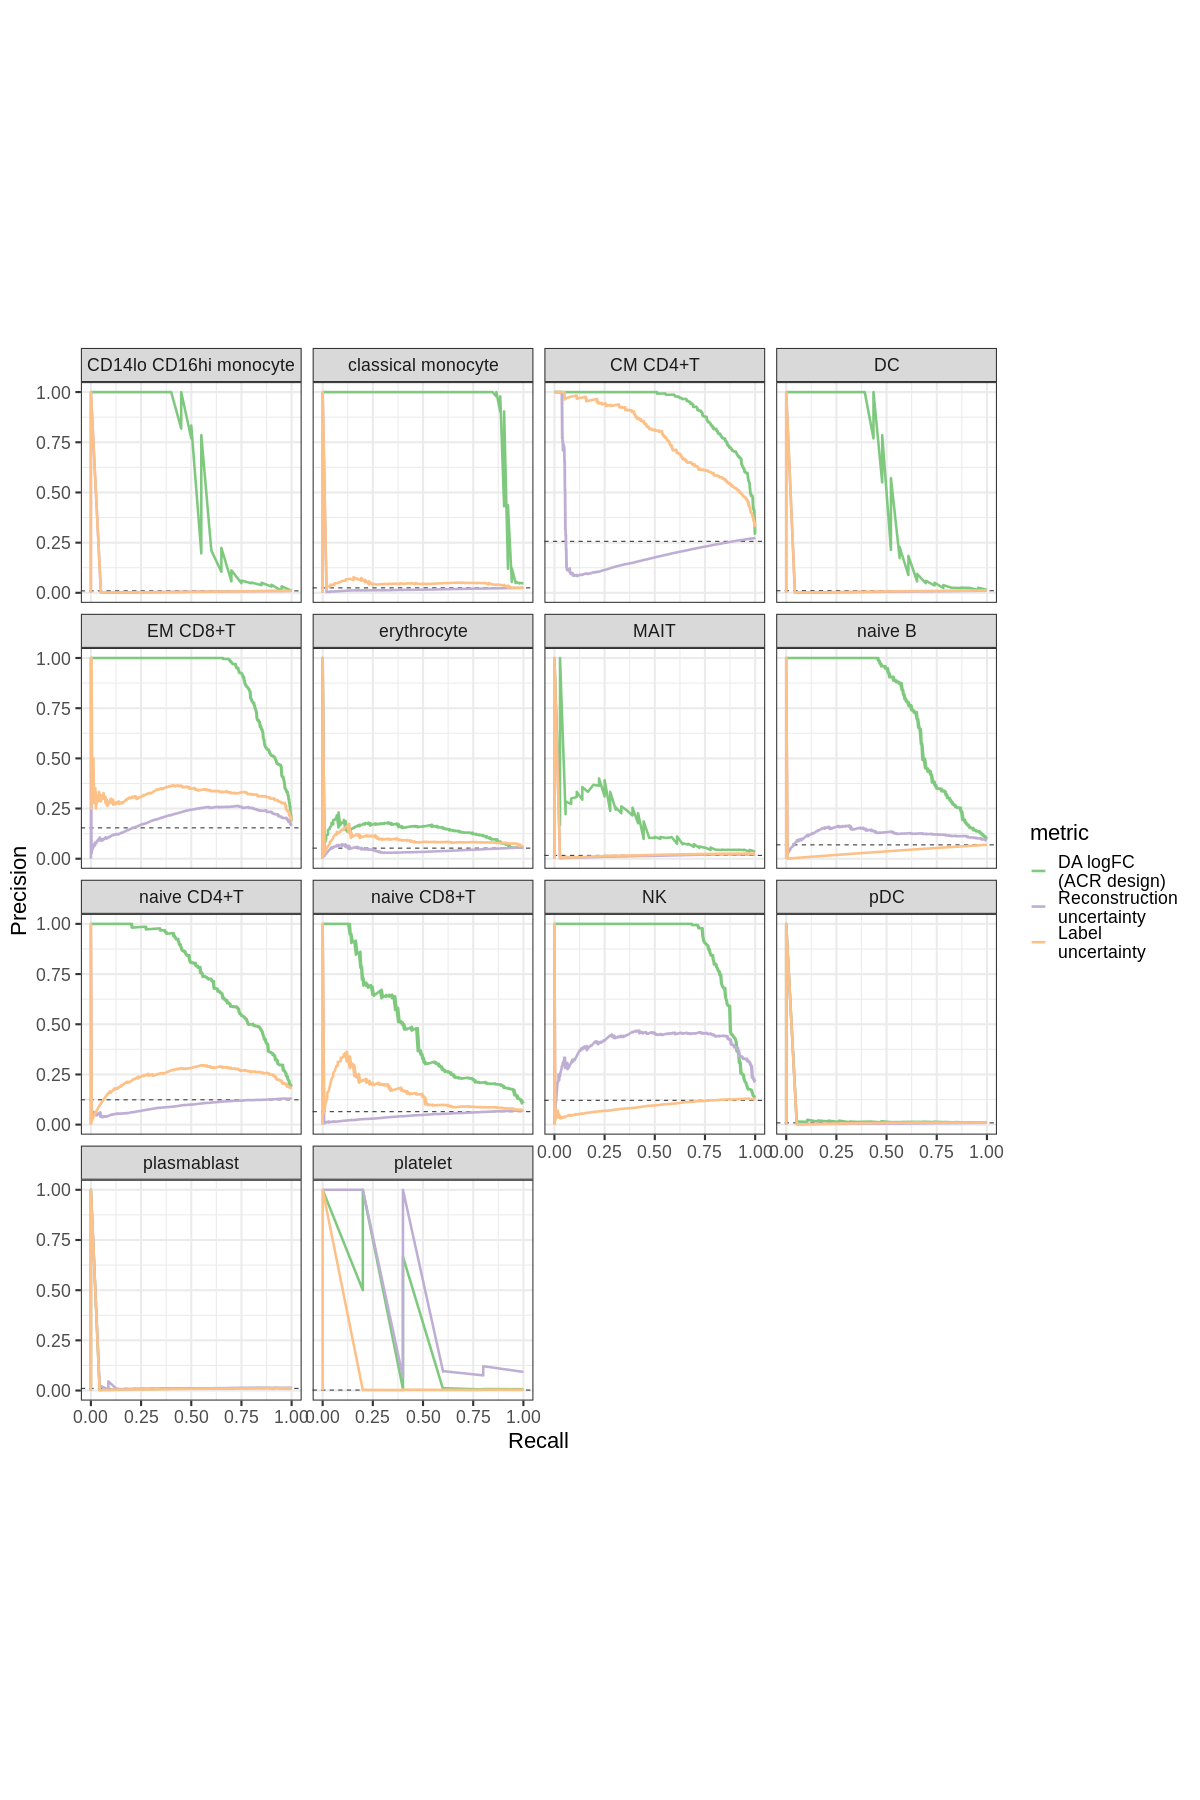

In [67]:
%%R -i figdir -w 1200 -h 1800
AUPRC_df_all %>%
    filter(design=='ACR') %>%
    ggplot(aes( Recall, Precision, group=metric, color=metric)) +
        geom_hline(aes(yintercept=no_skill_thresh), linetype=2, color='grey20') +
        geom_line(size=1.2) +
        facet_wrap(perturb_pop_pl~.) +
        scale_color_brewer(palette='Accent', 
                           labels=setNames(c('Reconstruction\nuncertainty', 'Label\nuncertainty', 'DA logFC\n(ACR design)'), c('unc_gex', 'unc_labels', 'logFC'))) +
        theme_bw(base_size=22) +
        coord_fixed() +
        ggsave(paste0(figdir, 'AUPRC_ACR_vs_uncertainty_curves.png'), width=16, height=16)

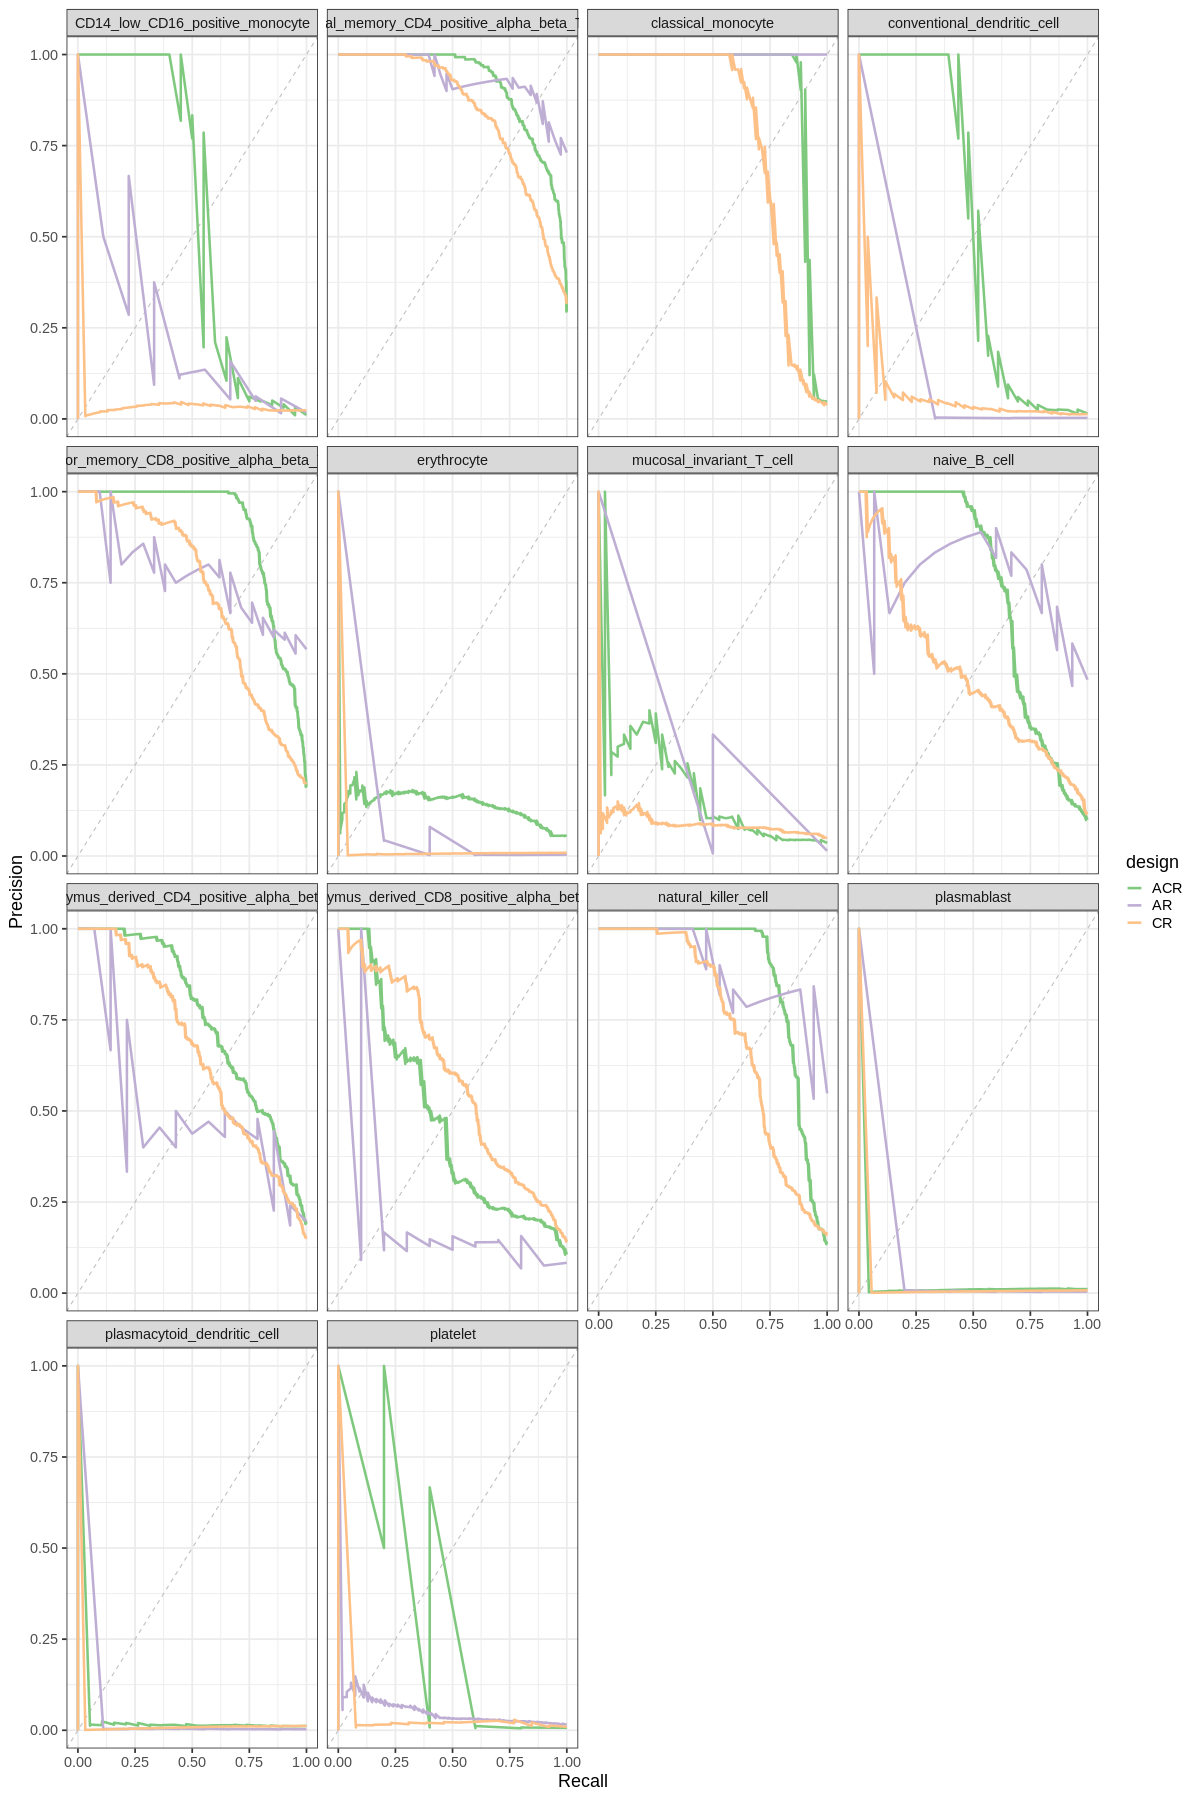

In [68]:
%%R -i figdir -w 1200 -h 1800
AUPRC_df_all %>%
    filter(metric=='logFC') %>%
    ggplot(aes( Recall, Precision, group=design, color=design)) +
        geom_abline(linetype=2, color='grey') +
        geom_line(size=1.2) +
        facet_wrap(perturb_pop~.) +
        scale_color_brewer(palette='Accent', labels=setNames(c('GEX uncertainty', 'Label\nuncertainty', 'DA logFC'), c('unc_gex', 'unc_labels', 'logFC'))) +
        theme_bw(base_size=18) 

In [106]:
%%R -i figdir -w 1500 -h 800
pl_ls <- lapply(c("AR", "CR", "ACR"), function(d){
    AUPRC_df_all %>%
        filter(design == d) %>%
        filter(!is.na(AUPRC)) %>%
        ggplot(aes( design, AUPRC, fill=metric)) +
        geom_col(position='dodge') +
        geom_hline(aes(yintercept=no_skill_thresh), linetype=2, color='grey20') +
            scale_fill_brewer(palette='Accent', 
                               labels=setNames(c('Reconstruction\nuncertainty', 'Label\nuncertainty', 'DA logFC'), c('unc_gex', 'unc_labels', 'logFC'))) +
            guides(fill=guide_legend(title.position='top')) +
            theme_bw(base_size=20) +
            facet_wrap(perturb_pop_pl~., scales='free', nrow=3) +
            coord_flip() +
            ylab('AUPRC') +
            theme(axis.text.y=element_blank(), 
                  axis.ticks.y=element_blank(),
                  axis.text.x=element_text(angle=45, hjust=1, vjust=1), 
                  legend.position='top', legend.justification='right') 
    })

wrap_plots(pl_ls[[2]]) +
plot_layout(ncol=1, guides='collect') &
theme(legend.position='top', legend.justification='right')
        ggsave(paste0(figdir, 'AUPRC_ACR_vs_uncertainty_barplots.png'), width=15, height=10) +
        ggsave(paste0(figdir, 'AUPRC_ACR_vs_uncertainty_barplots.pdf'), width=15, height=10)



integer(0)


`summarise()` has grouped output by 'design', 'metric'. You can override using the `.groups` argument.


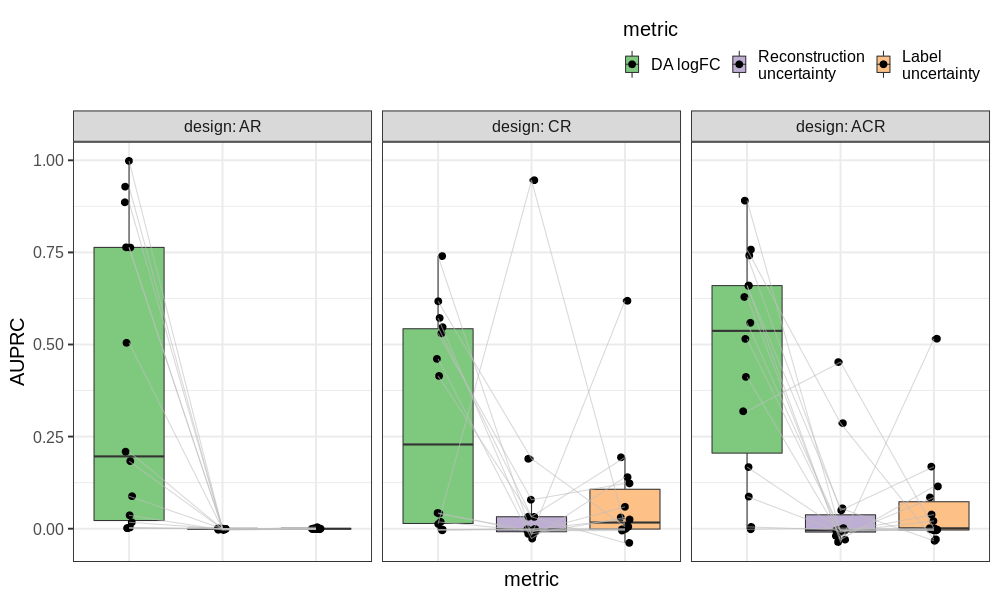

In [107]:
%%R -i figdir -w 1000 -h 600
AUPRC_df_all %>%
    filter(!is.na(AUPRC)) %>%
    mutate(design = factor(design, levels=c("AR", "CR", "ACR"))) %>%
    group_by(design, metric, perturb_pop) %>%
    summarise(AUPRC=mean(AUPRC), no_skill_thresh=mean(no_skill_thresh)) %>%
    ggplot(aes( metric, AUPRC - no_skill_thresh, fill=metric)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=perturb_pop), color='grey', alpha=0.6) +
        scale_fill_brewer(palette='Accent', 
                           labels=setNames(c('Reconstruction\nuncertainty', 'Label\nuncertainty', 'DA logFC'), c('unc_gex', 'unc_labels', 'logFC'))) +
        guides(fill=guide_legend(title.position='top')) +
        theme_bw(base_size=20) +
        facet_wrap(design~., scales='free_x', nrow=1, labeller='label_both') +
        ylab('AUPRC') +
        theme(axis.text.x=element_blank(), 
                  axis.ticks.x=element_blank(),
#                   axis.text.y=element_text(angle=45, hjust=1, vjust=1), 
                  legend.position='top', legend.justification='right') +
    ggsave(paste0(figdir, 'AUPRC_vs_uncertainty_boxplot.png'), width=12, height=5) +
    ggsave(paste0(figdir, 'AUPRC_vs_uncertainty_boxplot.pdf'), width=12, height=5)


### TPR/FPR
Using significance

In [109]:
cts = nhood_obs_all.perturb_pop.unique()
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha) & (nhood_obs_all.logFC > 0)
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood']) & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

tpr_df = nhood_obs_all.groupby(['design', 'perturb_pop']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
tpr_df['TPR'] = tpr_df['TP'] / (tpr_df['TP'] + tpr_df['FN'])
tpr_df['FPR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TN'])
tpr_df['FDR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df.loc[tpr_df['FDR'].isna(), 'FDR'] = 0
tpr_df['design'] = tpr_df['design'].astype('category').cat.reorder_categories(['AR', "CR", 'ACR'])
tpr_df

,design,perturb_pop,TP,FP,FN,TN,TPR,FPR,FDR
0,ACR,CD14_low_CD16_positive_monocyte,0,0,20,2042,0.000000,0.000000,0.000000
1,ACR,central_memory_CD4_positive_alpha_beta_T_cell,263,3,259,1509,0.503831,0.001984,0.011278
2,ACR,classical_monocyte,46,0,8,2048,0.851852,0.000000,0.000000
3,ACR,conventional_dendritic_cell,3,0,20,2196,0.130435,0.000000,0.000000
4,ACR,effector_memory_CD8_positive_alpha_beta_T_cell,202,0,118,1738,0.631250,0.000000,0.000000
5,ACR,erythrocyte,0,0,114,2045,0.000000,0.000000,0.000000
6,ACR,mucosal_invariant_T_cell,0,0,36,2123,0.000000,0.000000,0.000000
7,ACR,naive_B_cell,64,0,82,1970,0.438356,0.000000,0.000000
8,ACR,naive_thymus_derived_CD4_positive_alpha_beta_T...,60,0,195,1808,0.235294,0.000000,0.000000
9,ACR,naive_thymus_derived_CD8_positive_alpha_beta_T...,3,0,130,1924,0.022556,0.000000,0.000000


In [252]:
# with rc_context({'figure.figsize':[10,4]}):
#     plt.subplot(1,3,1)
#     sns.stripplot(data=tpr_df, y='TPR', x='design', s=10);
#     plt.ylim(-0.1,1.1);
#     plt.subplot(1,3,2)
#     sns.stripplot(data=tpr_df, y='FDR', x='design', s=10);
#     plt.ylim(-0.1,1.1);
#     plt.subplot(1,3,3)
#     sns.stripplot(data=tpr_df, y='FPR', x='design', s=10);
#     plt.ylim(-0.1,1.1);
#     plt.tight_layout()
#     plt.savefig(figdir+'TPR_FDR_TPR.png')

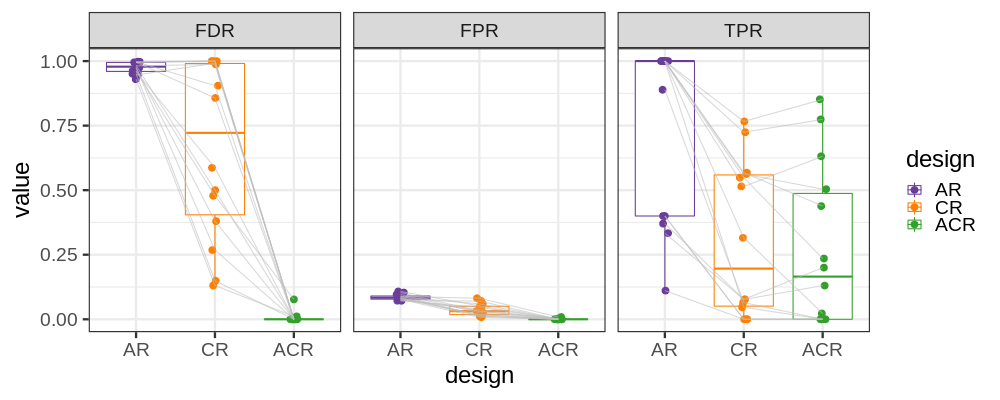

In [112]:
%%R -i tpr_df -w 1000 -h 400 -i design_palette_df

design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

pl1 <- tpr_df %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=perturb_pop), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24)
pl1 

`summarise()` has grouped output by 'design', 'metric'. You can override using the `.groups` argument.


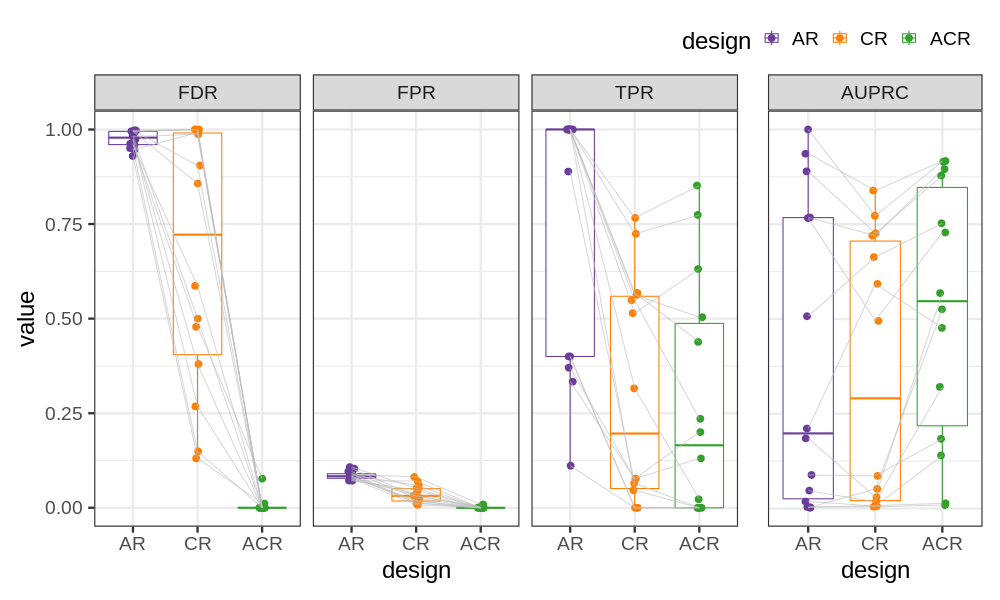

In [114]:
%%R -i figdir -w 1000 -h 600
pl2 <- AUPRC_df_all %>%
    filter(metric=='logFC') %>%
    group_by(design, metric, perturb_pop) %>%
    summarise(AUPRC=mean(AUPRC), no_skill_thresh=mean(no_skill_thresh)) %>%
    mutate(facet_name = 'AUPRC') %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) %>%
    ggplot(aes(design,  AUPRC, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=perturb_pop), color='grey', alpha=0.6) +
    ylab('value') +
    facet_wrap(facet_name~.) +
        scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    remove_y_axis()
    
fig <- (pl1 + pl2) + plot_layout(widths=c(3,1), guides='collect') & 
    {theme(legend.position='top', legend.justification='right')} 

fig +
    ggsave(paste0(figdir, 'metrics_boxplot_design.png'), width=12, height=5) +
    ggsave(paste0(figdir, 'metrics_boxplot_design.pdf'), width=12, height=5)

## Uncertainty delta in PAC across simulations

In [343]:
def add_nhood_uncertainties(pac_design_adata, query_group, ctrl_group):
    pac_design_adata.obs['conf_labels'] = 1 - pac_design_adata.obs['uncertainty_labels']
    pac_design_adata.obs['conf_gex'] = 1 - pac_design_adata.obs['uncertainty_gex']
#     pac_design_adata.obs['conf_z'] = 1 - pac_design_adata.obs['uncertainty_z']

    for c in ['conf_gex', 'conf_labels']:
        get_nhood_adata(pac_design_adata).obs[c + '_query'] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] == query_group], confidence_col=c)
        get_nhood_adata(pac_design_adata).obs[c + '_ctrl'] = get_mean_confidence_x_nhood(
            pac_design_adata, 
            obs_names = pac_design_adata.obs_names[pac_design_adata.obs['dataset_group'] == ctrl_group], confidence_col=c)

nhood_obs_all_unc = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if not x.endswith('.h5ad') and x.startswith('qPBMC')][1:]:
    perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad', backed=True)
    
    ### Define true positive neighbourhoods
    _add_perturb_pop_info(pac_design_adata)
    
    # ## Calculate avg confidence per nhood
    print(f'Calculating avg confidence')
    add_nhood_uncertainties(pac_design_adata, query_group='query', ctrl_group='ctrl')
    
    ## Store nhood info
    nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
    nhood_obs['perturb_pop'] = perturb_pop
    nhood_obs_all_unc = pd.concat([nhood_obs_all_unc, nhood_obs])

Reading conventional_dendritic_cell

Calculating avg confidence
Reading naive_B_cell

Calculating avg confidence
Reading central_memory_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading plasmablast

Calculating avg confidence
Reading platelet

Calculating avg confidence
Reading plasmacytoid_dendritic_cell

Calculating avg confidence
Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell

Calculating avg confidence
Reading classical_monocyte

Calculating avg confidence
Reading erythrocyte



/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Calculating avg confidence
Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading natural_killer_cell

Calculating avg confidence
Reading effector_memory_CD8_positive_alpha_beta_T_cell

Calculating avg confidence
Reading mucosal_invariant_T_cell

Calculating avg confidence
Reading CD14_low_CD16_positive_monocyte



OSError: [Errno 5] Can't read data (file read failed: time = Fri Aug 19 10:02:49 2022
, filename = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/pac_design.h5ad', file descriptor = 109, errno = 5, error message = 'Input/output error', buf = 0x557dcd22cb80, total read size = 557560, bytes this sub-read = 557560, bytes actually read = 18446744073709551615, offset = 0)

In [344]:
%%R -i nhood_obs_all_unc
colnames(nhood_obs_all_unc)

 [1] "index_cell"            "kth_distance"          "nhood_annotation"     
 [4] "nhood_annotation_frac" "logFC"                 "logCPM"               
 [7] "F"                     "PValue"                "FDR"                  
[10] "SpatialFDR"            "is_perturb_nhood"      "n_perturb_cells"      
[13] "n_cells"               "frac_perturb_cells"    "conf_gex_query"       
[16] "conf_gex_ctrl"         "conf_labels_query"     "conf_labels_ctrl"     
[19] "perturb_pop"          


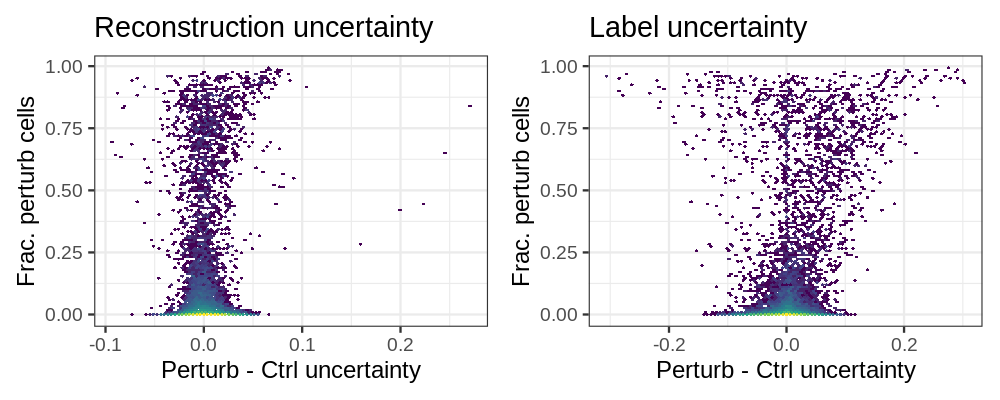

In [367]:
%%R -w 1000 -h 400
p1 <- nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_gex_ctrl > 0) %>%
mutate(unc_gex_query= 1 - conf_gex_query, unc_gex_ctrl=1-conf_gex_ctrl) %>%
ggplot(aes(unc_gex_query - unc_gex_ctrl, frac_perturb_cells)) +
    scale_color_viridis_c(option='magma') +
    theme_bw(base_size=16) +
        stat_binhex(aes(fill=log(..count..)), bins=100) +
        guides(fill=guide_colourbar(barwidth=10, ticks=FALSE, title.position='top')) +
        scale_fill_viridis_c() +
        theme_bw(base_size=24) +
        ylab('Frac. perturb cells') + xlab('Perturb - Ctrl uncertainty') +
        theme(legend.position='none') +
        ggtitle("Reconstruction uncertainty")
#         ggsave(paste0(figdir, 'fracVSunc_all_ggplot.png'), width=6, height=14) +
#         ggsave(paste0(figdir, 'fracVSunc_all_ggplot.pdf'), width=6, height=14)

p2 <- nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_labels_ctrl > 0) %>%
mutate(unc_labels_query= 1 - conf_labels_query, unc_labels_ctrl=1-conf_labels_ctrl) %>%
ggplot(aes(unc_labels_query - unc_labels_ctrl, frac_perturb_cells)) +
    scale_color_viridis_c(option='magma') +
    theme_bw(base_size=16) +
        stat_binhex(aes(fill=log(..count..)), bins=100) +
        guides(fill=guide_colourbar(barwidth=10, ticks=FALSE, title.position='top')) +
        scale_fill_viridis_c() +
        theme_bw(base_size=24) +
        ylab('Frac. perturb cells') + xlab('Perturb - Ctrl uncertainty') +
        theme(legend.position='none') +
        ggtitle("Label uncertainty")

(p1 + p2) + 
        ggsave(paste0(figdir, 'fracVSuncDelta_all_ggplot.png'), width=14, height=6) +
        ggsave(paste0(figdir, 'fracVSuncDelta_all_ggplot.pdf'), width=14, height=6)

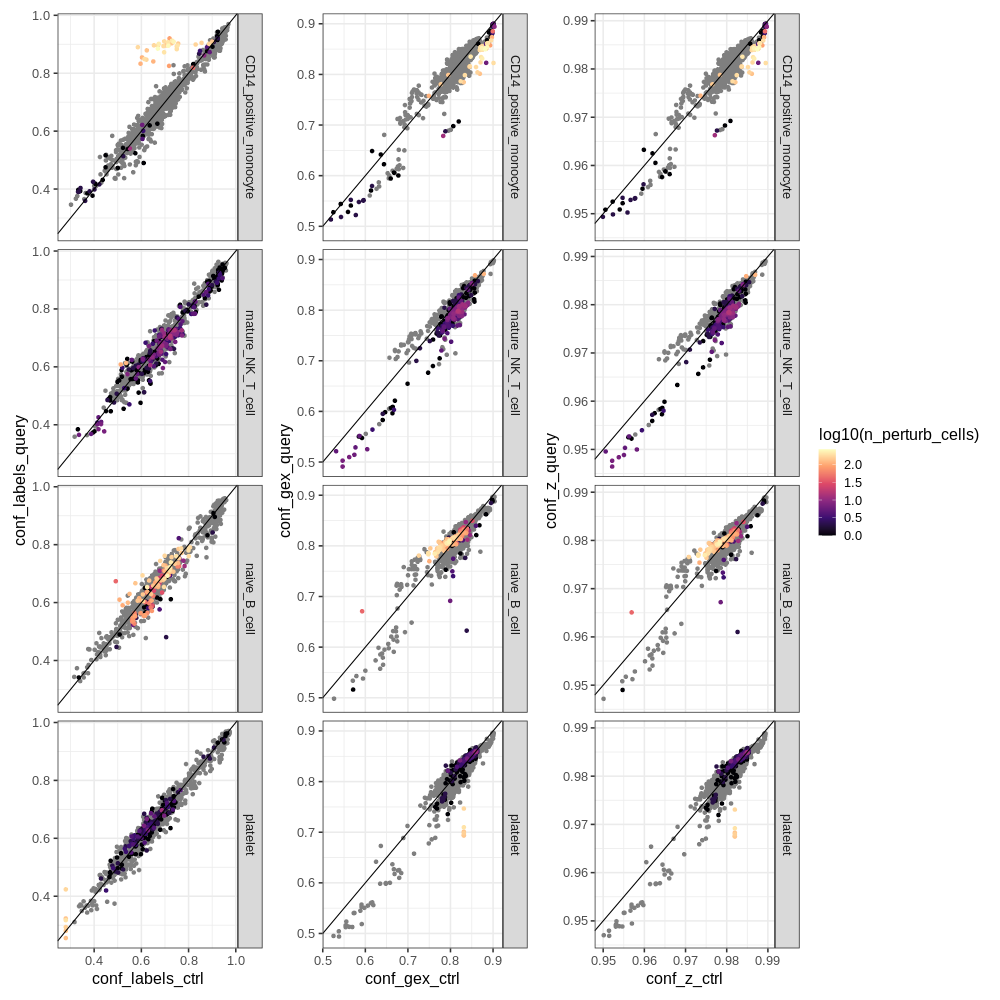

In [153]:
%%R -w 1000 -h 1000

nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_labels_ctrl > 0) %>%
ggplot(aes(conf_labels_ctrl, conf_labels_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +

nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_gex_ctrl > 0) %>%
ggplot(aes(conf_gex_ctrl, conf_gex_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +


nhood_obs_all_unc %>%
arrange(n_perturb_cells) %>%
filter(conf_z_ctrl > 0) %>%
ggplot(aes(conf_z_ctrl, conf_z_query, color=log10(n_perturb_cells))) +
    geom_point() +
    geom_abline() +
    scale_color_viridis_c(option='magma') +
    facet_grid(perturb_pop~.) +
    theme_bw(base_size=16) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'confidence_delta_scatter.png'), height=15, width=18)

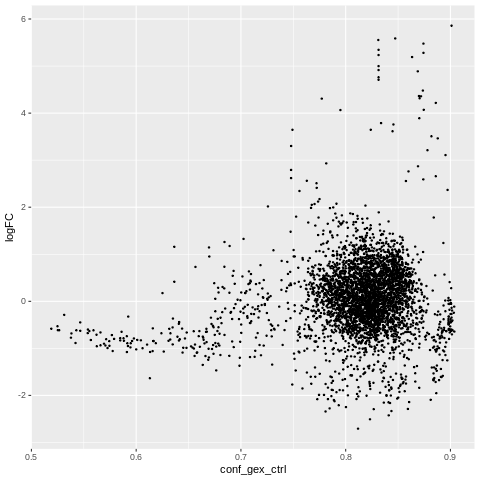

In [172]:
%%R 
nhood_obs_all_unc %>%
filter(conf_gex_ctrl > 0) %>%
ggplot(aes(conf_gex_ctrl, logFC)) +
geom_point(size=0.5) 

Compute Augur AUC for 3 designs
---

In [9]:
perturb_pop='mature_NK_T_cell'
d = f'qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

population_obs = 'cell_type'
perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
print(f'Reading {perturb_pop}\n')
pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad')
pc_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pc_design.h5ad')
pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad')

Reading mature_NK_T_cell



In [33]:
pa_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pa_design.h5ad')
## Restrict nhoods in PA design to where there is at least 20 query cell 
keep_nhoods = pa_design_adata[pa_design_adata.obs['is_query']].obsm['nhoods'].toarray().sum(0) > 10
pa_design_adata.obsm['nhoods'] = pa_design_adata.obsm['nhoods'][:,keep_nhoods]
pa_design_adata.uns['nhood_adata'] = pa_design_adata.uns['nhood_adata'][keep_nhoods].copy()


In [12]:
import diff2atlas
diff2atlas.augur_nhoods(pac_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)
diff2atlas.augur_nhoods(pc_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

Global seed set to 0


it 1
it 2
it 3
it 4
it 1
it 2
it 3
it 4


In [34]:
diff2atlas.augur_nhoods(pa_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 412, in _handle_workers
    pool._maintain_pool()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 248, in _maintain_pool
    self._repopulate_pool()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/pool.py", line 241, in _repopulate_pool
    w.start()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_

KeyboardInterrupt: 

In [16]:
_add_perturb_pop_info(pac_design_adata)
_add_perturb_pop_info(pc_design_adata)
_add_perturb_pop_info(pac_design_adata)

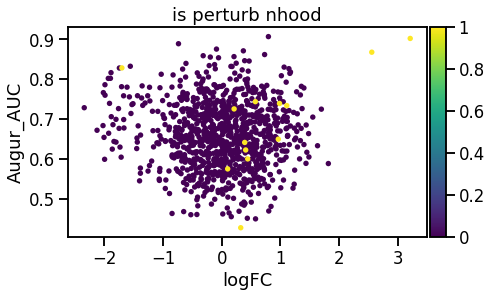

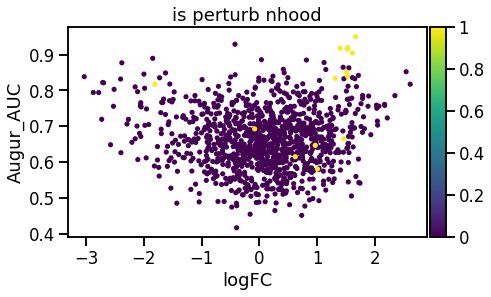

In [17]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC', color='is_perturb_nhood')
sc.pl.scatter(get_nhood_adata(pc_design_adata), 'logFC', 'Augur_AUC', color='is_perturb_nhood')

---
### Testing zone 

In [11]:
perturb_pop='mature_NK_T_cell'
d = f'qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [12]:
population_obs = 'cell_type'
perturb_pop = d.split(population_obs)[1].split('_queryBatch')[0]
print(f'Reading {perturb_pop}\n')
pac_design_adata = milopy.utils.read_milo_adata(outdir + d + '/pac_design.h5ad')

Reading mature_NK_T_cell



In [13]:
sc.tl.umap(pac_design_adata)

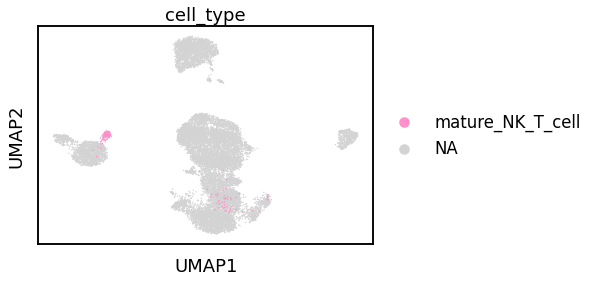

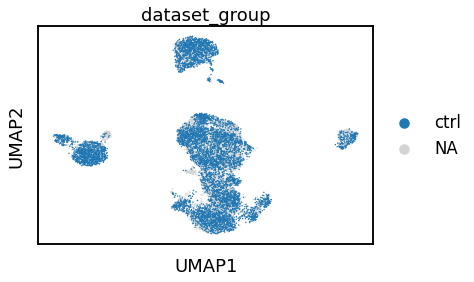

In [14]:
sc.pl.umap(pac_design_adata, color=population_obs, groups=[perturb_pop])
sc.pl.umap(pac_design_adata, color='dataset_group', groups='ctrl')

In [15]:
milopy.utils.build_nhood_graph(pac_design_adata)

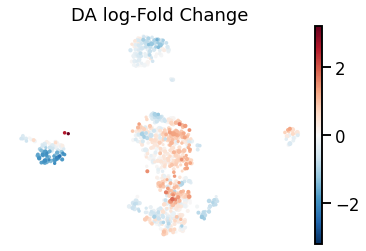

In [16]:
milopy.plot.plot_nhood_graph(pac_design_adata, min_size=0.3, alpha=1)

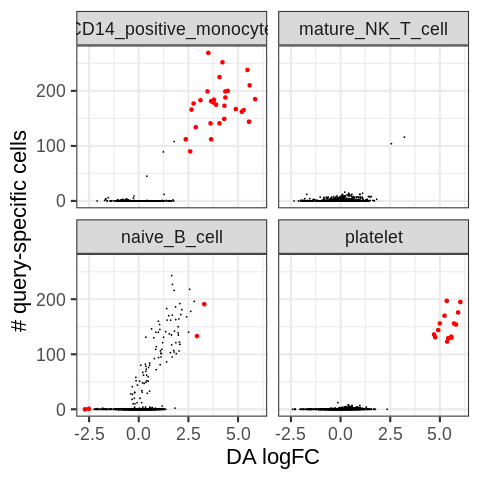

In [248]:
%%R 
nhood_obs_all %>%
filter(design == 'PAC') %>%
mutate(is_signif=SpatialFDR <= 0.1) %>%
ggplot(aes(logFC, n_perturb_cells)) +
geom_point(size=0.2) +
geom_point(data=. %>% filter(is_signif), color='red') +
facet_wrap(perturb_pop~.) +
theme_bw(base_size=22) +
ylab('# query-specific cells') + 
xlab('DA logFC') +
ggsave(paste0(figdir, 'n_perturb_cells.png'), height=8, width=9)

In [17]:
# def basic_AUGUR(nhood)
import diff2atlas
import anndata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def _nhood_augur(params):
    Y_nhood, X_nhood,test_size,subsample = params

    ## Feature selection
    hvgs = sc.pp.highly_variable_genes(anndata.AnnData(X_nhood), inplace=False)
    X_nhood = X_nhood[:,hvgs['highly_variable']]

    ## Split in train and test with subsampling 
    pos_ixs = np.where(Y_nhood==1)[0]
    neg_ixs = np.where(Y_nhood==0)[0]
    if subsample is not None:
        pos_ixs = np.random.choice(pos_ixs, subsample)
        neg_ixs = np.random.choice(neg_ixs, subsample)

    pos_train, pos_test = train_test_split(pos_ixs, test_size=test_size)
    neg_train, neg_test = train_test_split(neg_ixs, test_size=test_size)
    X_train = X_nhood[np.hstack([pos_train, neg_train]),:]
    X_test = X_nhood[np.hstack([pos_test, neg_test]),:]
    Y_train = Y_nhood[np.hstack([pos_train, neg_train])]
    Y_test = Y_nhood[np.hstack([pos_test, neg_test])]

    ## Train classifier on train
    est = LogisticRegression(penalty='l2', random_state=None)
    est.fit(X_train, Y_train)

    ## Predict in test
    Y_pred = est.predict(X_test)

    ## Compute AUC
    nhood_auc = roc_auc_score(Y_test, Y_pred)
    return(nhood_auc)

Global seed set to 0


In [18]:
condition_covariate = 'dataset_group'
ref_level = 'query'

Y = (pac_design_adata.obs[test_covariate] == ref_level).astype('int').values

if 'log1p' not in pac_design_adata.uns.keys():
    pac_design_adata.layers['counts'] = pac_design_adata.X.copy()
    sc.pp.normalize_per_cell(pac_design_adata)
    sc.pp.log1p(pac_design_adata)
# sc.pp.highly_variable_genes(pac_design_adata, subset=False)
# X = pac_design_adata[:,pac_design_adata.var.highly_variable].X.copy()
X = pac_design_adata.X.copy()


In [63]:
def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

nhood_mat = pac_design_adata.obsm['nhoods'].toarray()

nhood_mat_ref = nhood_mat[Y == 1,:]
nhood_mat_ctrl = nhood_mat[Y == 0,:]

[get_cells_from_nhood(pac_design_adata, 1)]

array([False, False, False, ..., False, False, False])

In [119]:
subsample=20
subsamples = []
for i in range(pac_design_adata.obsm['nhoods'].shape[1]): 
    pos_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==1))[0]
    neg_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==0))[0]
    if subsample is not None:
        pos_ixs = np.random.choice(pos_ixs, subsample)
        neg_ixs = np.random.choice(neg_ixs, subsample)
    subsamples.append(np.hstack([pos_ixs, neg_ixs]))
nhoods_sample_ixs = np.vstack(subsamples)

In [121]:
inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33, 20) for i in range(nhoods_sample_ixs.shape[0])]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
import multiprocessing
pool = multiprocessing.Pool(10)
inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33, 20) for i in range(nhoods_sample_ixs.shape[0])]

## Do 5-fold CV dei poveri 
aucs = np.array(pool.map(_nhood_augur, inputs))
for i in range(4):
    print(f'it {i+1}')
    aucs_i = np.array(pool.map(_nhood_augur, inputs))
    aucs = np.vstack([aucs, aucs_i])
    

it 1
it 2
it 3
it 4


In [42]:
get_nhood_adata(pac_design_adata).obs['Augur_AUC'] = aucs.mean(0)
get_nhood_adata(pac_design_adata).obs['size'] = pac_design_adata.obsm['nhoods'].toarray().sum(0)

(array([  7.,  37.,  77., 106., 227., 289., 147.,  94.,  25.,   7.]),
 array([0.47142857, 0.51428571, 0.55714286, 0.6       , 0.64285714,
        0.68571429, 0.72857143, 0.77142857, 0.81428571, 0.85714286,
        0.9       ]),
 <BarContainer object of 10 artists>)

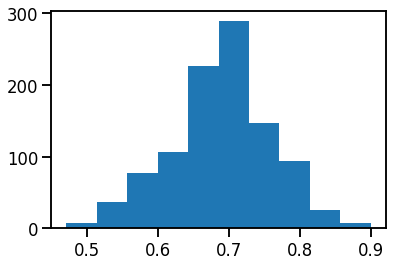

In [43]:
plt.hist(get_nhood_adata(pac_design_adata).obs['Augur_AUC'])

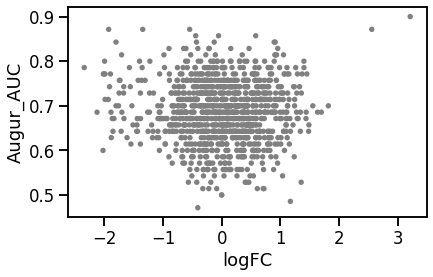

In [44]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC')

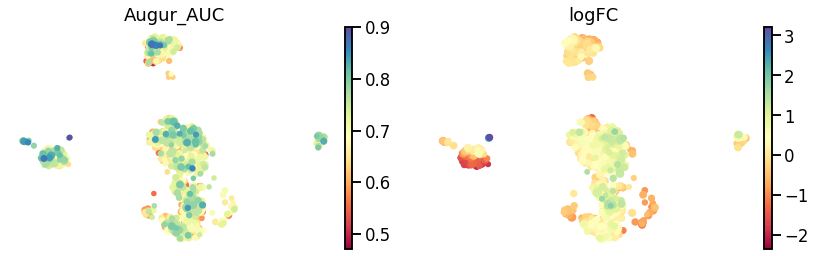

In [47]:
diff2atlas.plotting.plot_nhood_graph(pac_design_adata, color=['Augur_AUC', 'logFC'], min_size=1, cmap='Spectral')

In [123]:
def augur_nhoods(adata,                   
                test_covariate: str,
                ref_level: str = None,
                n_folds: int = 5,
                sample_size: int = 20,
                n_workers: int = 5 
                ) -> None:
    """Compute Augur

    Params:
    ------
    - adata: AnnData object
    - test_covariate: which covariate stores the condition of interest 
    - ref_level: which level of test_covariate to set to 1
    - n_folds: how many permutations to compute AUC on
    - sample_size: how many cells from each condition to downsample to 
        (crucial, otherwise AUC dependent on no of cells from each condition in nhood) 
    - n_workers: for multiprocessing 
    """
    try:
        nhood_adata = adata.uns['nhood_adata'].copy()
    except:
        raise ValueError(
            "adata.uns['nhood_adata'] not found -- please run nhood_confidence first")

    Y = (pac_design_adata.obs[test_covariate] == ref_level).astype('int').values

    if 'log1p' not in pac_design_adata.uns.keys():
        pac_design_adata.layers['counts'] = pac_design_adata.X.copy()
        sc.pp.normalize_per_cell(pac_design_adata)
        sc.pp.log1p(pac_design_adata)
    
    X = pac_design_adata.X.copy()

    ### Make array w nhood x cell indexes (sample subsample of cells x nhood)
    subsamples = []
    for i in range(pac_design_adata.obsm['nhoods'].shape[1]): 
        pos_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==1))[0]
        neg_ixs = np.where((get_cells_from_nhood(pac_design_adata, i)) & (Y==0))[0]
        
        pos_ixs = np.random.choice(pos_ixs, sample_size)
        neg_ixs = np.random.choice(neg_ixs, sample_size)
        subsamples.append(np.hstack([pos_ixs, neg_ixs]))
    nhoods_sample_ixs = np.vstack(subsamples)

    pool = multiprocessing.Pool(n_workers)
    inputs = [(Y[nhoods_sample_ixs[i,:]], X[nhoods_sample_ixs[i,:],:], 0.33) for i in range(nhoods_sample_ixs.shape[0])]

    ## Do 5-fold CV dei poveri 
    aucs = np.array(pool.map(_nhood_augur, inputs))
    for i in range(4):
        print(f'it {i+1}')
        aucs_i = np.array(pool.map(_nhood_augur, inputs))
        aucs = np.vstack([aucs, aucs_i])
    
    get_nhood_adata(pac_design_adata).obs['Augur_AUC'] = aucs.mean(0)
    



def _nhood_augur(params):
    Y_nhood, X_nhood, test_size = params

    ## Feature selection
    hvgs = sc.pp.highly_variable_genes(anndata.AnnData(X_nhood), inplace=False)
    X_nhood = X_nhood[:,hvgs['highly_variable']]

    ## Split in train and test with subsampling 
    X_train, X_test, Y_train, Y_test = train_test_split(X_nhood, Y_nhood, test_size=test_size)
    
    ## Train classifier on train
    est = LogisticRegression(penalty='l2', random_state=None)
    est.fit(X_train, Y_train)

    ## Predict in test
    Y_pred = est.predict(X_test)

    ## Compute AUC
    nhood_auc = roc_auc_score(Y_test, Y_pred)
    return(nhood_auc)

In [125]:

augur_nhoods(pac_design_adata, test_covariate='dataset_group', ref_level='query', n_workers=10)

it 1
it 2
it 3
it 4


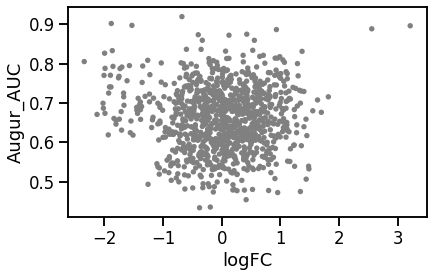

In [128]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC', 'Augur_AUC')

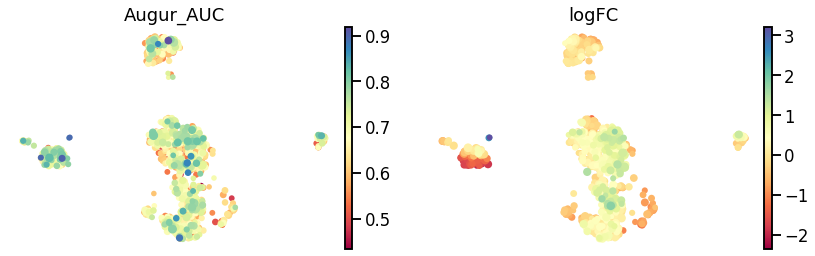

In [129]:
diff2atlas.plotting.plot_nhood_graph(pac_design_adata, color=['Augur_AUC', 'logFC'], min_size=1, cmap='Spectral')


In [273]:
nhoods_

NameError: name 'nhoods_all_df' is not defined